In [67]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualization

import tensorflow as tf # Deep Learning
import tensorflow_hub as hub # Pre-trained models
 

# Data Preprocessing

In [68]:
df = pd.read_csv('twitter_training.csv', usecols= ['Tweet','Result']) # Read the data only with the columns that we need
df.head() # Show the first 5 rows of the data

,Result,Tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Result  74682 non-null  object
 1   Tweet   73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


As we can see, there are missing values in the data. We will drop the missing values. Because it is a small amount of data.

In [70]:
df.dropna(inplace=True) # Drop the missing values

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Result  73996 non-null  object
 1   Tweet   73996 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [72]:
df['Result'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

Here we can see that we have four unique values in the Result column (Positive, Negative, Neutral, Irrelevant). We cant use the irrelevant data for our model. So we will drop the irrelevant data too.

In [73]:
# Define the condition for irrelevant lines
condition = df['Result'] == 'Irrelevant'

# Get the indices of irrelevant lines
irrelevant_indices = df[condition].index

# Drop the irrelevant lines
df.drop(irrelevant_indices, inplace=True)

In [74]:
df['Result'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

Now need to convert the labels to numerical values. We will convert the labels to 0, 1, 2. 0 for Negative, 1 for Neutral, 2 for Positive.

In [75]:
df['Result'] = df['Result'].apply(lambda x: 0 if x == 'Negative' else (1 if x == 'Neutral' else 2)) # Convert the labels to numerical values

In [76]:
df['Result'].unique()
df.head()

,Result,Tweet
0,2,im getting on borderlands and i will murder yo...
1,2,I am coming to the borders and I will kill you...
2,2,im getting on borderlands and i will kill you ...
3,2,im coming on borderlands and i will murder you...
4,2,im getting on borderlands 2 and i will murder ...


Check if data is balanced

In [77]:
len(df[df['Result'] == 0]) , len(df[df['Result'] == 1]) , len(df[df['Result'] == 2]) # Count the number of each label

(22358, 18108, 20655)

Data is balanced. Now we can convert the data to a tensorflow dataset.

In [78]:
# function that converts a panda dataframe to a tensorflow dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024): # Function to convert a dataframe to a dataset
    df = dataframe.copy() # avoid modifying the original dataframe
    labels = df.pop("Result") # Remove the label column from the dataframe
    df = df["Tweet"] # Keep only the description column
    ds = tf.data.Dataset.from_tensor_slices((df, labels)) # Create a tensorflow dataset
    if shuffle: # Shuffle the dataset if needed
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)  # Batch the dataset
    ds = ds.prefetch(tf.data.AUTOTUNE) # automatically tune the number of batches to prefetch based on the current runtime conditions
    return ds

In [79]:
train, val , test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))]) # Split the data into train, validation and test sets with 80%, 10% and 10% of the data 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [80]:
train_data = df_to_dataset(train) # Convert the train dataframe to a tensorflow dataset
val_data = df_to_dataset(val) # Convert the validation dataframe to a tensorflow dataset
test_data = df_to_dataset(test) # Convert the test dataframe to a tensorflow dataset

# Model

In [81]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2" # Load the embedding model
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True) # Create a keras layer with the embedding model

In [82]:
model = tf.keras.Sequential() # Create a sequential model
model.add(hub_layer) # Add the pre-trained layer
model.add(tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Add a hidden layer with 16 neurons
model.add(tf.keras.layers.Dense(3, activation='softmax')) # Add an output layer with 1 neuron and a sigmoid activation function

In [83]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # gradient descent algorithm
    loss =  tf.keras.losses.SparseCategoricalCrossentropy(), # loss function
    metrics = ['accuracy']
)

In [84]:
model.evaluate(train_data) # Evaluate the model on the test data

48/48 [==============================] - 0s 3ms/step - loss: 1.3914 - accuracy: 0.2828


[1.3914159536361694, 0.28276342153549194]

In [85]:
model.evaluate(val_data) # Evaluate the model on the validation data

6/6 [==============================] - 0s 4ms/step - loss: 1.3919 - accuracy: 0.2788


[1.3919270038604736, 0.2787958085536957]

In [86]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 5
)

Epoch 1/5
48/48 [==============================] - 8s 156ms/step - loss: 1.2731 - accuracy: 0.4371 - val_loss: 1.1790 - val_accuracy: 0.5717
Epoch 2/5
48/48 [==============================] - 8s 159ms/step - loss: 1.0790 - accuracy: 0.6487 - val_loss: 0.9889 - val_accuracy: 0.6795
Epoch 3/5
48/48 [==============================] - 8s 156ms/step - loss: 0.8741 - accuracy: 0.7297 - val_loss: 0.8185 - val_accuracy: 0.7405
Epoch 4/5
48/48 [==============================] - 7s 154ms/step - loss: 0.7034 - accuracy: 0.7941 - val_loss: 0.7044 - val_accuracy: 0.7754
Epoch 5/5
48/48 [==============================] - 7s 153ms/step - loss: 0.5806 - accuracy: 0.8427 - val_loss: 0.6258 - val_accuracy: 0.8058


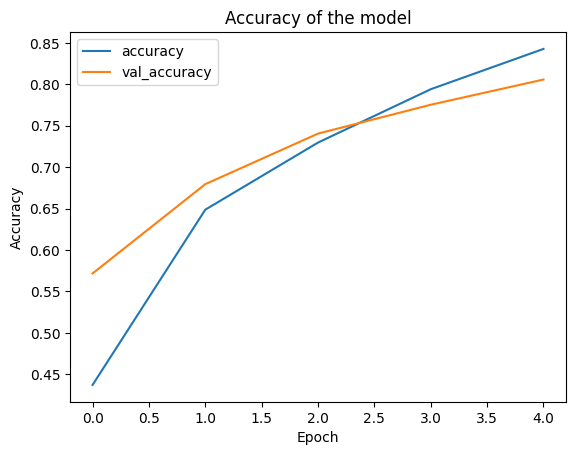

In [87]:
plt.plot(history.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

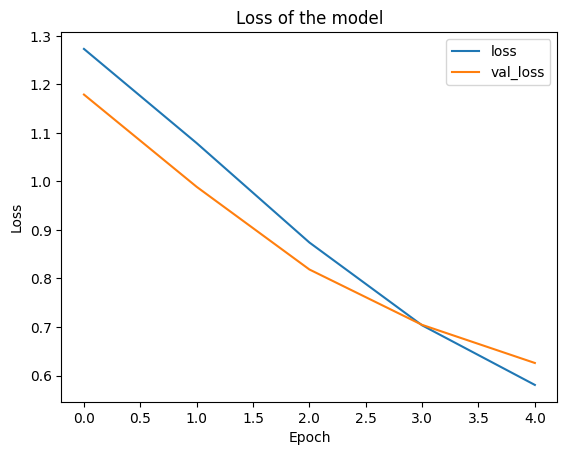

In [88]:
plt.plot(history.history['loss'], label='loss') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_loss'], label = 'val_loss') # Plot the accuracy of the model on the validation data
plt.title('Loss of the model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
model.evaluate(test_data) # Evaluate the model on the test data

6/6 [==============================] - 0s 24ms/step - loss: 0.6332 - accuracy: 0.8009


[0.633197009563446, 0.8009160757064819]